In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm 

In [7]:
df = pd.read_csv('eda_hospital.csv')

## Next Step: Decision Tree Regressor

A Decision Tree Regressor is a natural next step because:
- **Non-linear modeling:** It can automatically capture complex, non-linear patterns without feature engineering.
- **Flexibility:** It partitions the feature space into regions, adapting to different hospital, DRG, and severity subgroups.
- **Interpretability:** Trees provide clear rules for how features impact cost.
- **Ease of use:** No need for feature scaling or normalization.

Thus, moving to a decision tree model can better capture the segmented and non-linear structure of the data, particularly improving predictions for high-cost cases where the linear model underperformed.

In [ ]:
# Prepare feature set
features = [
    'Yes Surgical',
    'APR DRG Code Encoded',
    'Facility Id Encoded',
    'Severity_x_Facility',
    'Severity_x_DRG',
    'Facility_x_DRG',
    'Discharges',
    'APR Severity of Illness Code'
]

X = df[features].copy()
y_train_full = df['Mean Cost W']    # 训练用Mean Cost W
y_val_full = df['Mean Cost'] 

# Convert categorical variables if necessary
X['Yes Surgical'] = X['Yes Surgical'].astype(float)
X['APR Severity of Illness Code'] = X['APR Severity of Illness Code'].astype(float)

# Initialize Decision Tree model
dt_model = DecisionTreeRegressor(
    max_depth=12,
    min_samples_leaf=500,
    random_state=42
)

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store overall metrics
rmse_list, mae_list, r2_list = [], [], []

print("5-Fold Cross Validation...")
print("=" * 40)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X), total=5), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

    y_train = y_train_full.iloc[train_idx] 
    y_val = y_val_full.iloc[val_idx]   

    # Fit model
    dt_model.fit(X_train, y_train)

    # Predict
    y_val_pred = dt_model.predict(X_val)

    # Metrics on original scale
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    # Save metrics
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    # Print current fold results
    print(f"\nFold {fold} Results:")
    print("=" * 40)
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print("=" * 40)

5-Fold Cross Validation...


 20%|██        | 1/5 [00:05<00:20,  5.10s/it]


Fold 1 Results:
  RMSE: 14860.54
  MAE: 7077.08
  R²: 0.7402


 40%|████      | 2/5 [00:10<00:15,  5.01s/it]


Fold 2 Results:
  RMSE: 14829.88
  MAE: 7069.11
  R²: 0.7422


 60%|██████    | 3/5 [00:15<00:10,  5.17s/it]


Fold 3 Results:
  RMSE: 14803.19
  MAE: 7061.11
  R²: 0.7413


 80%|████████  | 4/5 [00:20<00:05,  5.11s/it]


Fold 4 Results:
  RMSE: 14702.77
  MAE: 7052.82
  R²: 0.7417


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


Fold 5 Results:
  RMSE: 14779.74
  MAE: 7039.11
  R²: 0.7419


## Decision Tree Performance Summary

In [9]:
print("\nOverall Cross-Validation Summary:")
print("=" * 40)
print(f"Mean RMSE: {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")
print(f"Mean MAE: {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
print(f"Mean R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


Overall Cross-Validation Summary:
Mean RMSE: 14795.22 ± 53.51
Mean MAE: 7059.84 ± 13.14
Mean R²: 0.7414 ± 0.0007


## Performance Evaluation

Across 5-fold cross-validation, the Decision Tree Regressor achieved:

- Mean R² ≈ 0.741
- Average RMSE ≈ $14,795
- Average MAE ≈ $7,060

Compared to the **linear regression**, the Decision Tree demonstrated stronger performance in terms of both **error reduction** and **explaination of variation**.

This suggests that the Decision Tree was able to capture some of the **non-linear** relationships.

It also shows that our feature engineering works successfully interms of **accuracy** and **training time**.

## Feature Importance Graph Analysis

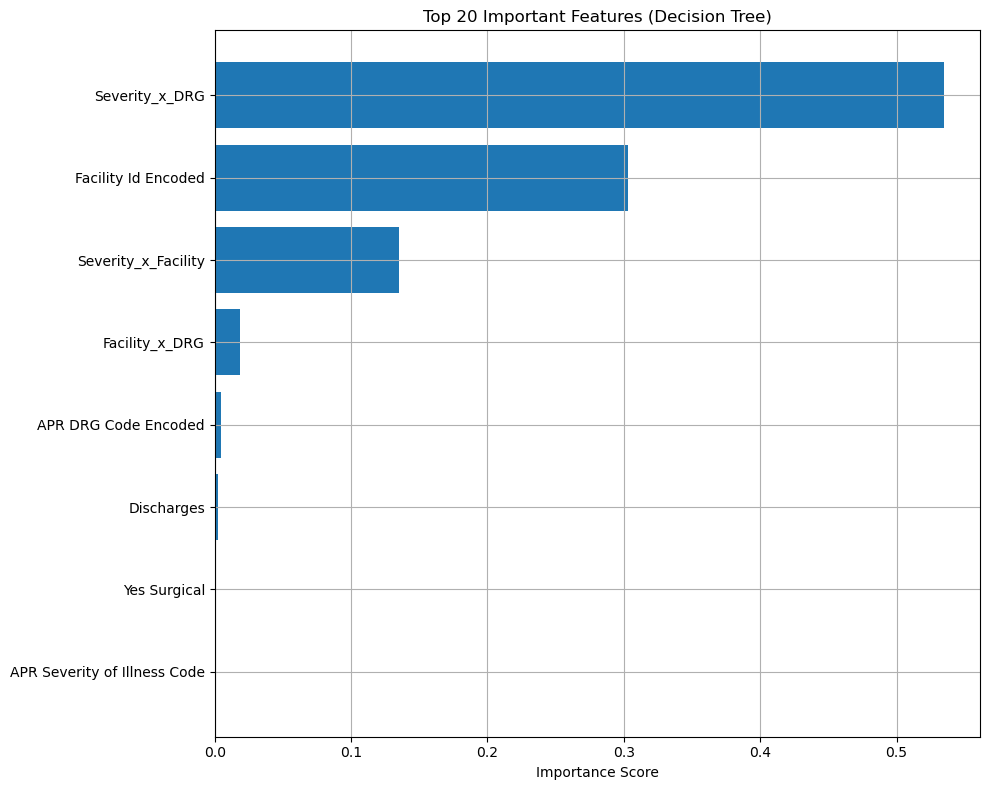

In [10]:
# Feature Importance Visualization
feature_importances = dt_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].iloc[:top_n][::-1], importance_df['Importance'].iloc[:top_n][::-1])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Important Features (Decision Tree)')
plt.grid(True)
plt.tight_layout()
plt.show()

From the feature importance plot, we observe that the model **heavily relies** on a few features, especially **Severity_x_DRG** and **Facility Id Encoded**.

This suggests that the model may be **overfitting to specific feature interactions** and failing to utilize the full information available in the dataset.

As a next step, we plan to explore **ensemble model**： such as Random Forests + XGBoost to **address the limitations** observed in the single Decision Tree model.

## Next Step: Ensemble